In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from qiskit import IBMQ, execute
import qiskit.tools.jupyter
from qiskit import pulse
from qiskit.pulse import pulse_lib

In [4]:
IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
cmd_def = pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
config = backend.configuration()

In [6]:
anh_almaden = [-320.2, -319.7, -317.2, -320.6, -322.0, -322.5,
               -269.1, -297.1, -320.4, -325.0, -318.7, -319.5,
               -321.1, -319.8, -322.7, -325.5, -320.9, -321.3,
               -321.6, -323.0]

In [7]:
anh = anh_almaden

In [8]:
backend

<IBMQBackend('alt_almaden') from IBMQ(hub='ibm-q-dev', group='qiskit-terra', project='pulse-testing')>

------------

In [9]:
MEASUREMENT_START_TIMESTEP = 500

In [10]:
# just measure
schedule0 = pulse.Schedule()
schedule0 |= measure << MEASUREMENT_START_TIMESTEP

#job = execute(schedule, backend=backend, shots=1000, meas_level=1, meas_return='single')
#print(job.job_id())

In [11]:
# X, then measure
schedule1 = pulse.Schedule()
schedule1 |= cmd_def.get('x', qubits=[0])
schedule1 |= measure << MEASUREMENT_START_TIMESTEP

#job = q.execute(schedule, backend=backend, shots=1000, meas_level=1, meas_return='single')
#print(job.job_id())

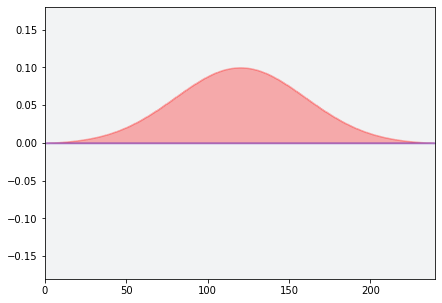

In [13]:
# Approximate X as a gaussian pulse:
DURATION = 240
AMP = 0.10
SIGMA = 40
pulse_lib.gaussian(duration=DURATION, amp=AMP, sigma=SIGMA).draw(scaling=0.18)

In [22]:
# X, then pulse at 1-2 frequency, then measure
schedule2 = pulse.Schedule()
schedule2 |= cmd_def.get('x', qubits=[0])

freq = config.dt * -anh[0]/1000  # anharmonicity is 312 MHz. In units of dt, we have .304/ns * config.dt/ns
wave_samples = pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * pulse.pulse_lib.sin(
            duration=DURATION, amp=1, freq=freq).samples
# use amplitude of AMP / sqrt(2) for 1->2 transition
gaussian_samples = pulse.pulse_lib.gaussian(duration=DURATION, amp=AMP / np.sqrt(2), sigma=SIGMA).samples
schedule2 |= pulse.SamplePulse(gaussian_samples * wave_samples)(config.drive(0)) << schedule2.duration

schedule2 |= measure << MEASUREMENT_START_TIMESTEP

#job = q.execute(schedule, backend=backend, shots=1000, meas_level=1, meas_return='single')
#print(job.job_id())

In [21]:
backend.status()

BackendStatus(backend_name='alt_almaden', backend_version='1.2.4', operational=True, pending_jobs=0, status_msg='active')

In [29]:
schedule0.draw(plot_range=[0, 500], channels_to_plot=[config.drive(0)])

TypeError: can only concatenate list (not "NoneType") to list

<Figure size 432x288 with 0 Axes>

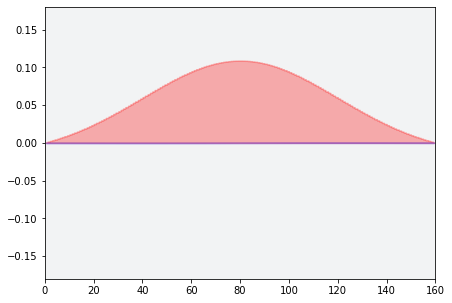

In [16]:
cmd_def.get('x', qubits=[0]).instructions[0][1].command.draw(scaling=0.18)

In [17]:
cmd_def.get('x', qubits=[0]).instructions[0][1].command.samples

array([ 0.00084972 -7.85212469e-05j,  0.00173157 -8.14578598e-05j,
        0.00264603 -8.44378010e-05j,  0.00359357 -8.74574980e-05j,
        0.00457460 -9.05131237e-05j,  0.00558950 -9.36005599e-05j,
        0.00663860 -9.67153974e-05j,  0.00772216 -9.98529649e-05j,
        0.00884042 -1.03008308e-04j,  0.00999354 -1.06176194e-04j,
        0.01118164 -1.09351116e-04j,  0.01240474 -1.12527312e-04j,
        0.01366285 -1.15698749e-04j,  0.01495586 -1.18859149e-04j,
        0.01628363 -1.22001991e-04j,  0.01764592 -1.25120525e-04j,
        0.01904243 -1.28207772e-04j,  0.02047276 -1.31256544e-04j,
        0.02193647 -1.34259491e-04j,  0.02343299 -1.37209034e-04j,
        0.02496171 -1.40097487e-04j,  0.02652189 -1.42916993e-04j,
        0.02811275 -1.45659564e-04j,  0.02973338 -1.48317151e-04j,
        0.03138280 -1.50881577e-04j,  0.03305995 -1.53344634e-04j,
        0.03476365 -1.55698101e-04j,  0.03649266 -1.57933711e-04j,
        0.03824563 -1.60043244e-04j,  0.04002113 -1.62018507e-

In [31]:
job = execute([schedule0, schedule1, schedule2], backend=backend, shots=1000, meas_level=1, meas_return='single')

In [32]:
job.status()

<JobStatus.VALIDATING: 'job is being validated'>

In [ ]:
for j in backend.jobs(limit=3):
    print(j.job_id())
    print(j.status())

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(1, 3)
i = 0
fig.set_size_inches(14,7)

for (job, title) in zip(backend.jobs(limit=3), ['X, then 1->2, then measure', 'X, then measure', 'Just measure']):
    result = job.result()
    memory_shots = result.get_memory()
    qubit_0_readouts = [memory_shot[0] for memory_shot in memory_shots]

    ax = axes[i]
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('I (a.u.)', fontsize=16)
    ax.set_ylabel('Q (a.u.)', fontsize=16)
    ax.scatter(np.real(qubit_0_readouts) * 1e-10, np.imag(qubit_0_readouts) * 1e-10,
               s=1, cmap='viridis',c='blue',alpha=0.5)
    i += 1

In [ ]:
schedule.draw(plot_range=(0, 1000))

In [ ]:
backend.properties().gates[7]

In [ ]:
import json
with open("/Users/alijavadi/Desktop/ajavadia-terra/qiskit/test/mock/config_burlington.json", "w+") as f:
    json.dump(backend.configuration().to_dict(), f)

In [ ]:
config.hamiltonian

In [ ]:
backend